In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
import os, sys
import numpy as np
import pandas as pd

import config_readwrite as crw

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")
import plot_params as pp

pp.fonts()

('sans-serif', 'Arial', 18)

# config

In [2]:
# read
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

In [3]:
CL = "HEPG2"
DATAHEPG2 = config["mpra"][f'{CL}.clean.transformed'] 

CL = "BJ"
DATABJ = config["mpra"][f'{CL}.clean.transformed'] 

FASTA = config["mpra"]["fasta"]

MEME = config["meme"]["src"]
FIMO = config["fimo"]["src"]
RESULTS = config["path"]["results"]
BED = config["mpra"]["tile.bed"]

RE_MEME = os.path.join(RESULTS, "meme")
RE_MEME_CL = os.path.join(RE_MEME, CL)

# make the results
for dirname in [RE_MEME, RE_MEME_CL]:
    if os.path.exists(dirname) is False:
        os.mkdir(dirname)

# append meme path
sys.path.append(MEME)

# change directory 
os.chdir(RE_MEME_CL)

In [4]:
# write

section = "meme"

config[section][f'results'] = RE_MEME
config[section][CL] = RE_MEME_CL

crw.write(config, cfn)

# load data

In [5]:
def openAndFilter(file_name):
    df = pd.read_csv(file_name, sep='\t')  # (58333, 38)
    print("before filtering", file_name,  df.shape)
    df = df.loc[~df["label"].str.contains("Synthetic")].reset_index(
        drop=True)  # (26803, 38)
    print("filter out synthetics", df.shape)
    df = df.loc[~df["label"].str.contains("Pos")].reset_index(
        drop=True)  # (26659, 38)
    print("filter out positive controls", df.shape, '\n\n')

    return df

In [6]:
#hepg2 = openAndFilter(DATAHEPG2)
bj = openAndFilter(DATABJ)

before filtering /wynton/group/ahituv/fongsl/projects/US/data/full_bj_MPRA.clean.transformed.csv (58333, 38)
filter out synthetics (26803, 38)
filter out positive controls (26659, 38) 




In [7]:
bj.shape

(26659, 38)

In [8]:
enh = pd.read_csv(BED, sep='\t')
enh.head()

,name,enh.id,enh.name
0,hob_k27ac_down_chr1:826978-827247,chr1:826978-827704,enh.0
1,hob_k27ac_down_chr1:827110-827379,chr1:826978-827704,enh.0
2,hob_k27ac_down_chr1:827377-827646,chr1:826978-827704,enh.0
3,hob_k27ac_down_chr1:827435-827704,chr1:826978-827704,enh.0
4,hob_k27ac_down_chr1:827891-828160,chr1:827891-828160,enh.1


In [9]:
bj = pd.merge(bj, enh, how="left")

# add direction 

In [10]:
def labelDirection(df):

    """label sequences with different directions of change between US and Control
    note

    neg.US_UP == US MPRA activity is negative, but less negative than CTRL MPRA activity, which is also negative
    pos.US_UP  == US MPRA activity is positive and more positive than CTRL MPRA activity, which is also positive. 
    US_UP == US activity is positive and higher than CTRL MPRA activity, which is negative. 
    """
    df["direction"] = None

    # Pos values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Pos.US_UP"

    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Pos.CTRL_UP"

    # Negtaive values only
    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "Neg.CTRL_DOWN"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] < 0),
           "direction"] = "Neg.US_DOWN"

    # crossing zero values only
    df.loc[(df["l2.ratio.mean.us"] > 0) &
           (df["l2.ratio.mean.ctrl"] < 0) &
           (df["delta.mean"] > 0),
           "direction"] = "US_UP"

    df.loc[(df["l2.ratio.mean.us"] < 0) &
           (df["l2.ratio.mean.ctrl"] > 0) &
           (df["delta.mean"] < 0),
           "direction"] = "CTRL_UP"

    print(df.loc[df["direction"] != None, ["l2.ratio.mean.ctrl",
          "l2.ratio.mean.us", 'delta.mean', "direction"]].sample(n=20))
    return df


In [11]:
bj = labelDirection(bj)

       l2.ratio.mean.ctrl  l2.ratio.mean.us  delta.mean      direction
23470            0.203643          0.191454   -0.012190    Pos.CTRL_UP
20211           -0.170510         -0.149817    0.020693  Neg.CTRL_DOWN
12678            0.236548          0.277101    0.040552      Pos.US_UP
3996             0.412465          0.447781    0.035316      Pos.US_UP
23743            0.204772          0.196481   -0.008290    Pos.CTRL_UP
6069            -0.053922          0.163263    0.217184          US_UP
26422           -1.164594         -1.166965   -0.002371    Neg.US_DOWN
21349           -0.036731         -0.054713   -0.017982    Neg.US_DOWN
25584           -0.216808         -0.223542   -0.006734    Neg.US_DOWN
5366             0.022547          0.069319    0.046772      Pos.US_UP
23127           -0.198322         -0.204550   -0.006228    Neg.US_DOWN
19132            0.126068          0.105181   -0.020887    Pos.CTRL_UP
19503            0.321723          0.310368   -0.011354    Pos.CTRL_UP
6353  

# make fasta from luc

In [13]:
LUC="/wynton/group/ahituv/fongsl/projects/US/data/validation_luc/Candidate_ID_table_luc.txt"

luc = pd.read_csv(LUC, sep='\t')

luc.head()

luc_names = luc[["Sample name", "insert"]].copy()

luc_in_bj = pd.merge(bj, luc_names, left_on="name", right_on="insert")

luc_mpra_names=set(luc_in_bj["name"])  # get set of names tested in luc

# US up - BJ

In [15]:
EXP_NAME ="exp5.luc"
DIRECTION = "US_UP"
df = bj

In [16]:
def getDfDirectionSub(df, direction):
    """subset dataframe by directino of effect"""
    
    cols = ["name", "label", "l2.ratio.mean.ctrl",
        'l2.ratio.mean.us', "delta.mean", "direction"]

    df = df.loc[df["direction"] == direction, cols].sort_values(by='l2.ratio.mean.us', ascending=False).copy()

    return df



def makeFasta(names, direction, re, exp_name, fa):
    """write fastas for each quantile based on list of sequence names"""
    
    
    # files to write
    FA = os.path.join(re, f"{exp_name}.{direction}.fa")

    
    # write positive, negative names and sequences

    fa_writer = open(FA, "w") # open fa file to write

    with open(fa, "r") as reader:  # open the full fa file
        for value in sfp(reader):
            seq_id, seq = value  # get sequence id, sequence
            if seq_id in names:  # filter for sequences in pos/neg name list
                fa_writer.write(f'>{seq_id}\n{seq}\n')  # write those sequences to fa
    fa_writer.close()
        
    return FA

def runFimo(fimo, meme_txt, fa, direction, exp):

    OUTDIR = f"./fimo/{direction}.{exp}"
    cmd = " ".join([fimo,
                    "--oc",
                    OUTDIR,
                    meme_txt,
                    fa,

                    ])
    os.system(cmd)

    return OUTDIR

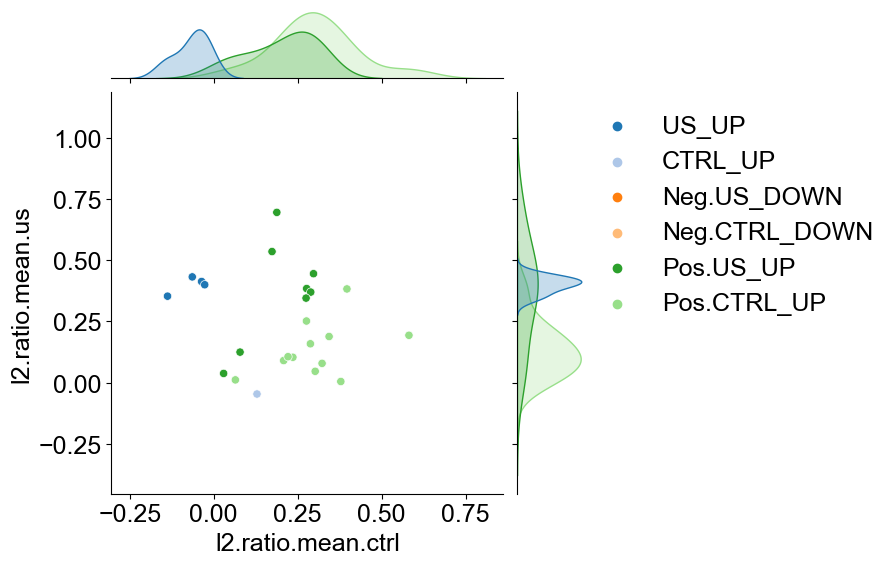

In [17]:

# make fa of luc names
FA = makeFasta(luc_mpra_names,  DIRECTION, RE_MEME_CL, EXP_NAME, FASTA)

plot = luc_in_bj
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

## functions

        bottom 0.1 US_UP bkgd discovered motifs
        CAGRCTCTCS
        CCTGKRTGWGW
        GAGRAGVMAGCMK
        
        bottom0.1 US_UP and shuffle bkgd
        AGGAGGMAGC
        AGRSCCCAGC
        CARRCTCTCCT

In [18]:
TOP_QUANTILE =0.9
MEME_TXT = os.path.join(RE_MEME_CL, f"{CL}.{DIRECTION}.{TOP_QUANTILE}.meme.txt")

In [19]:
OUTDIR_LUC=  runFimo(FIMO, MEME_TXT, FA, DIRECTION, EXP_NAME)

Using motif +CCCWGGCYCCTGC of width 13.
Using motif -CCCWGGCYCCTGC of width 13.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.873233
#   Estimated pi_0=0.886667
Using motif +ASHCWGGMCTGG of width 12.
Using motif -ASHCWGGMCTGG of width 12.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.943673
#   Estimated pi_0=0.955169
Using motif +CAGCWKYYCC of width 10.
Using motif -CAGCWKYYCC of width 10.
Computing q-values.
# Computing q-values.
#   Estimating pi_0 from a uniformly sampled set of 10000 p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.956063
#   Estimated pi_0=0.961379


In [28]:
bottom_pred = os.path.join(OUTDIR_LUC, "fimo.tsv")


bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'luc'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)


# concatenate the top and bottom values
plot = bdf



(35, 12)


In [26]:
merged = pd.merge(bdf, luc_in_bj, right_on= "name", left_on="sequence_name")
merged.head()

,motif_id,motif_alt_id,sequence_name,start,stop,strand,score,p-value,q-value,matched_sequence,...,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,direction,-log10p,enh.id,enh.name,Sample name,insert
0,CAGCWKYYCC,MEME-3,bj_k27ac_up_chr4:53763341-53763610,66.0,75.0,+,15.83490,0.000007,0.0792,CAGCATCCCC,...,0.431428,0.041973,0.520849,0.495254,US_UP,2.015071,chr4:53763341-53764193,enh.8052,BJ_U8,bj_k27ac_up_chr4:53763341-53763610
1,CAGCWKYYCC,MEME-3,bj_k27ac_up_chr4:53763341-53763610,57.0,66.0,+,9.20183,0.000028,0.1160,CAGCAGTGCC,...,0.431428,0.041973,0.520849,0.495254,US_UP,2.015071,chr4:53763341-53764193,enh.8052,BJ_U8,bj_k27ac_up_chr4:53763341-53763610
2,CCCWGGCYCCTGC,MEME-1,bj_k27ac_up_chr4:53763341-53763610,114.0,126.0,+,8.93578,0.000039,0.0590,CCCTGGCTCTCTC,...,0.431428,0.041973,0.520849,0.495254,US_UP,2.015071,chr4:53763341-53764193,enh.8052,BJ_U8,bj_k27ac_up_chr4:53763341-53763610
3,CCCWGGCYCCTGC,MEME-1,bj_k27ac_up_chr4:53763341-53763610,108.0,120.0,+,8.74312,0.000042,0.0590,CTCAGGCCCTGGC,...,0.431428,0.041973,0.520849,0.495254,US_UP,2.015071,chr4:53763341-53764193,enh.8052,BJ_U8,bj_k27ac_up_chr4:53763341-53763610
4,CCCWGGCYCCTGC,MEME-1,bj_k27ac_up_chr4:53763341-53763610,254.0,266.0,-,7.84404,0.000059,0.0590,CCCACCCTCCACC,...,0.431428,0.041973,0.520849,0.495254,US_UP,2.015071,chr4:53763341-53764193,enh.8052,BJ_U8,bj_k27ac_up_chr4:53763341-53763610


In [ ]:
merged['correct'] = False
correct = ["BJ_U9",
           "BJ_D2",
           "BJ_D4",
           "BJ_D7",
           "BJ_D8",
           "BJ_D9",
           #"HEPG2_D1",
           #"HEPG2_D2",
           #"HEPG2_D3",
           #"HEPG2_D4",
           #"HEPG2_D8",
           #"HEPG2_U1",
           ]

merged.loc[merged["Sample name"].isin(correct), "correct"] = True
merged.head()

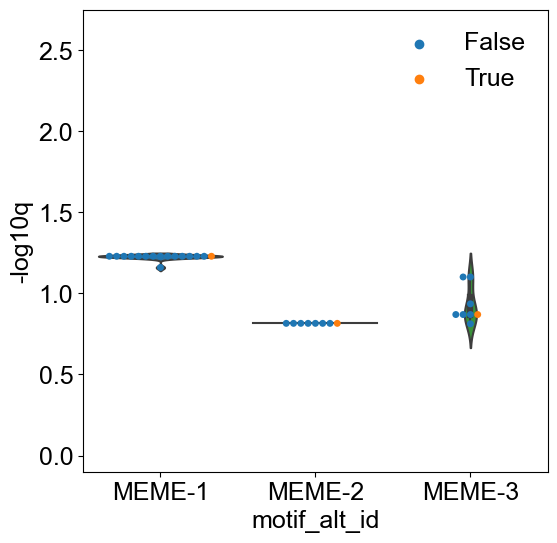

In [34]:
fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= merged, #hue="correct", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
sns.swarmplot(x="motif_alt_id", y='-log10q', data= merged, hue="correct", 
               order = ["MEME-1", "MEME-2", "MEME-3"])

ax.set(ylim=(-0.10,2.75))
ax.legend(frameon=False, bbox_to_anchor = (1,1)) 

In [35]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

NameError: name 'tdf' is not defined

## Experiment 2: are motifs discovered in US_UP also discovered in POS.US_UP?
    - hypothesis: top motifs in us_up are also driving increased activity in pos.US_up. 
    - approach: use FIMO to discover US_UP motifs in other data. 
    - data universe: sequences with positive baseline activity that increase activity w/ US

In [ ]:
EXP_NAME ="exp2"
DIRECTION = "Pos.US_UP"

### pos.us_up sequences only

In [ ]:
### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means, no shuffle data leakage
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

### clean up data leakage
- tiled enhancers which may have overlapping information

In [ ]:
def getEnhSet(df, name_set):
    enh_names = df.loc[df["name"].isin(name_set), "enh.name"].unique()
    linkedtiles = df.loc[df["enh.name"].isin(enh_names), "name"].unique()
    
    return enh_names, linkedtiles

In [ ]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [ ]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)

# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

### sanity check

In [ ]:
shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
             stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False,
             stat="percent")
plt.legend(frameon=False, loc="upper left")



shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

## Fimo

### top 

In [ ]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

### FET enrichment

In [ ]:
OUTDIR_BOTTOM

In [ ]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"]  = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"]  = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

fig, ax= plt.subplots( figsize = (6,6))
sns.violinplot(x="motif_alt_id", y='-log10q', data= plot, hue="quantile", 
               order = ["MEME-1", "MEME-2", "MEME-3"])
ax.set(ylim=(-0.10,2.75))
ax.legend(frameon=False, loc='upper left')

In [ ]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

## experiment 3 - loss of enrichmetn in CTRL_UP

In [ ]:
EXP_NAME ="exp3"
DIRECTION = "CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [ ]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [ ]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
             stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [ ]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

In [ ]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.set(ylim=(-0.20,2.75))
ax.legend(frameon=False, loc='upper left')

In [ ]:
IDS = ["MEME-1", "MEME-2", "MEME-3"]
VAL =  "-log10q" #"score"
for ID in IDS: 

    a = tdf.loc[tdf["motif_alt_id"]==ID, VAL]
    b = bdf.loc[bdf["motif_alt_id"]==ID, VAL]
    print(ID, stats.mannwhitneyu(a,b))

## experiment 4

In [ ]:
EXP_NAME ="exp4"
DIRECTION = "Pos.CTRL_UP"

### subset df by direction. 

df_dir = getDfDirectionSub(df, DIRECTION)

### top and bottom 10% of direction changes. 

# top quantile of delta.means
pos, pos_names, neg, neg_names = getQuantileDelta(df_dir, TOP_QUANTILE, df, False)

plot = pd.concat([pos, neg])
# fig,ax = plt.subplots(figsize=(6,6))
hue_order = ['US_UP',
             'CTRL_UP',
             'Neg.US_DOWN',
             'Neg.CTRL_DOWN',
             'Pos.US_UP',
             'Pos.CTRL_UP',
             ]

g = sns.jointplot(x="l2.ratio.mean.ctrl", y="l2.ratio.mean.us",
                  data=plot, hue="direction", hue_order=hue_order,
                  palette='tab20'
                 )
g.ax_joint.legend(frameon=False, bbox_to_anchor=(2, 1))

In [ ]:
# get enh ids, linked tiles from exp1 dataset
exp1pos_enhnames, exp1pos_linkedtiles = getEnhSet(bj, exp1up)
exp1neg_enhnames, exp1neg_linkedtiles = getEnhSet(bj, exp1down)

In [ ]:
# remove exp 1 linked tiles
pos_names_clean = set(pos_names).difference(set(exp1pos_linkedtiles))
neg_names_clean = set(neg_names).difference(set(exp1neg_linkedtiles))

# make fasta files from quantiles. 
FA_POS, FA_NEG = makeQuantileFasta(pos_names_clean, neg_names_clean, DIRECTION, RE_MEME_CL, TOP_QUANTILE, EXP_NAME, FASTA)


# add to config
config[section][f'{CL}.{DIRECTION}.{TOP_QUANTILE}.fa'] = FA_POS
config[section][f'{CL}.{DIRECTION}.{BOTTOM_QUANTILE}.fa'] = FA_NEG

crw.write(config, cfn)

shuf = bj.loc[bj["label"] == "Shuffle"]
genome = bj.loc[bj["label"] != "Shuffle"]

fig, ax = plt.subplots()

"""
sns.histplot(x="delta.mean", data=df_dir,
             label=f"{DIRECTION}", stat="percent", kde=True,
             color="w", common_norm=False
            )
            
"""
sns.histplot(x="delta.mean", data=shuf, label="shuffle", kde=True,
             stat="percent", color="grey", common_norm=False)
sns.histplot(x="delta.mean", data=pos, label=f"{DIRECTION} top {TOP_QUANTILE}",
             kde=True,common_norm=False, #color="orange", 
             stat="percent")
sns.histplot(x="delta.mean", data=neg, label=f"{DIRECTION} bottom {BOTTOM_QUANTILE}",
             kde=True,common_norm=False, #color="blue",
             stat="percent")
plt.legend(frameon=False, loc="upper left")

shuf["delta.mean"].quantile(0.975), pos["delta.mean"].describe()

pos.describe(), neg.describe()

In [ ]:
OUTDIR_TOP =  runFimo(FIMO, MEME_TXT, FA_POS, DIRECTION, TOP_QUANTILE)
OUTDIR_BOTTOM =  runFimo(FIMO, MEME_TXT, FA_NEG, DIRECTION, BOTTOM_QUANTILE)

In [ ]:
bottom_pred = os.path.join(OUTDIR_BOTTOM, "fimo.tsv")
top_pred = os.path.join(OUTDIR_TOP, "fimo.tsv")

tdf = pd.read_csv(top_pred, sep='\t')
tdf["quantile"] = 'top0.9'
tdf["-log10q"] = -1*np.log10(tdf["q-value"])
print(tdf.shape)
tdf.head()

bdf = pd.read_csv(bottom_pred, sep='\t')
bdf["quantile"] = 'bottom0.1'
bdf["-log10q"] = -1*np.log10(bdf["q-value"])
print(bdf.shape)
bdf.head()

# concatenate the top and bottom values
plot = pd.concat([tdf, bdf])

fig, ax = plt.subplots(figsize=(6, 6))
sns.violinplot(x="motif_alt_id", y='-log10q', data=plot, hue="quantile",
               #hue_order=["bottom0.1", "top0.1"],
               order=["MEME-1", "MEME-2", "MEME-3"])
ax.set(ylim=(-0.20,2.75))
ax.legend(frameon=False, loc='upper left')

In [ ]:
# make fa for luciferase tested elements. 

In [ ]:
LUC="/wynton/group/ahituv/fongsl/projects/US/data/validation_luc/Candidate_ID_table_luc.txt"